<a href="https://colab.research.google.com/github/bishair/Pirna/blob/main/ModelG10Pirna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
uploaded_file = files.upload()

Saving riverL.xlsx to riverL.xlsx


In [4]:
# Read the groundwater level data
gw_data = pd.read_excel('groundwater.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
print(gw_data)

# Read the river water level data
river_data = pd.read_excel('riverL.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

resampled_data = merged_data.resample('H').ffill()
resampled_data = resampled_data[1:]
print(resampled_data)

'''
has_nan = resampled_data.isna().any().any()
print(has_nan)
total_nan_count = resampled_data.isna().sum().sum()
print(total_nan_count)
nan_per_column = resampled_data.isna().any()
print(nan_per_column)
nan_count_per_column = resampled_data.isna().sum()
print(nan_count_per_column)'''


                     Date      G10
0     2015-01-30 12:18:00  110.722
1     2015-01-30 13:18:00  110.720
2     2015-01-30 14:18:00  110.718
3     2015-01-30 15:18:00  110.715
4     2015-01-30 16:18:00  110.714
...                   ...      ...
17533 2017-01-30 10:19:00  109.456
17534 2017-01-30 11:19:00  109.455
17535 2017-01-30 12:19:00  109.456
17536 2017-01-30 13:19:00  109.457
17537 2017-01-30 14:19:00  109.459

[17329 rows x 2 columns]
                         G10  River
Date                               
2015-01-30 13:00:00  110.722  261.0
2015-01-30 14:00:00  110.720  260.0
2015-01-30 15:00:00  110.718  260.0
2015-01-30 16:00:00  110.715  260.0
2015-01-30 17:00:00  110.714  260.0
...                      ...    ...
2017-01-30 10:00:00  109.457  135.0
2017-01-30 11:00:00  109.456  136.0
2017-01-30 12:00:00  109.455  138.0
2017-01-30 13:00:00  109.456  141.0
2017-01-30 14:00:00  109.457  144.0

[17546 rows x 2 columns]


'\nhas_nan = resampled_data.isna().any().any()\nprint(has_nan)\ntotal_nan_count = resampled_data.isna().sum().sum()\nprint(total_nan_count)\nnan_per_column = resampled_data.isna().any()\nprint(nan_per_column)\nnan_count_per_column = resampled_data.isna().sum()\nprint(nan_count_per_column)'

In [5]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(resampled_data)

print(data_scaled)

[[0.8510427  0.66666667]
 [0.85004965 0.66287879]
 [0.8490566  0.66287879]
 ...
 [0.22194638 0.20075758]
 [0.2224429  0.21212121]
 [0.22293942 0.22348485]]


In [6]:
# Creating sequences
n_steps=24
X, y = [], []
for i in range(n_steps, len(data_scaled)):
      X.append(data_scaled[i-n_steps:i, :])
      y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)
print('X',X)
print('y',y)
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X [[[0.8510427  0.66666667]
  [0.85004965 0.66287879]
  [0.8490566  0.66287879]
  ...
  [0.83366435 0.65909091]
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]]

 [[0.85004965 0.66287879]
  [0.8490566  0.66287879]
  [0.84756703 0.66287879]
  ...
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]]

 [[0.8490566  0.66287879]
  [0.84756703 0.66287879]
  [0.84707051 0.66287879]
  ...
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]
  [0.82969215 0.67045455]]

 ...

 [[0.24428997 0.21590909]
  [0.2428004  0.21212121]
  [0.2428004  0.20833333]
  ...
  [0.224429   0.18181818]
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]]

 [[0.2428004  0.21212121]
  [0.2428004  0.20833333]
  [0.24230387 0.20454545]
  ...
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]]

 [[0.2428004  0.20833333]
  [0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  ...
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]]]
y [0.831

In [7]:
print(X_train, X_train.shape)

[[[0.8510427  0.66666667]
  [0.85004965 0.66287879]
  [0.8490566  0.66287879]
  ...
  [0.83366435 0.65909091]
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]]

 [[0.85004965 0.66287879]
  [0.8490566  0.66287879]
  [0.84756703 0.66287879]
  ...
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]]

 [[0.8490566  0.66287879]
  [0.84756703 0.66287879]
  [0.84707051 0.66287879]
  ...
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]
  [0.82969215 0.67045455]]

 ...

 [[0.33416087 0.25      ]
  [0.33316783 0.25      ]
  [0.33217478 0.24621212]
  ...
  [0.31479643 0.23484848]
  [0.31479643 0.23484848]
  [0.31380338 0.23863636]]

 [[0.33316783 0.25      ]
  [0.33217478 0.24621212]
  [0.33167825 0.24242424]
  ...
  [0.31479643 0.23484848]
  [0.31380338 0.23863636]
  [0.31330685 0.23106061]]

 [[0.33217478 0.24621212]
  [0.33167825 0.24242424]
  [0.3306852  0.24242424]
  ...
  [0.31380338 0.23863636]
  [0.31330685 0.23106061]
  [0.31330685 0.23106061]]] (12265, 24

In [8]:
print(X_test, X_test.shape)

[[[0.33167825 0.24242424]
  [0.3306852  0.24242424]
  [0.32919563 0.24242424]
  ...
  [0.31330685 0.23106061]
  [0.31330685 0.23106061]
  [0.31181728 0.23106061]]

 [[0.3306852  0.24242424]
  [0.32919563 0.24242424]
  [0.32869911 0.23863636]
  ...
  [0.31330685 0.23106061]
  [0.31181728 0.23106061]
  [0.31132075 0.23106061]]

 [[0.32919563 0.24242424]
  [0.32869911 0.23863636]
  [0.32770606 0.23863636]
  ...
  [0.31181728 0.23106061]
  [0.31132075 0.23106061]
  [0.30983118 0.23106061]]

 ...

 [[0.24428997 0.21590909]
  [0.2428004  0.21212121]
  [0.2428004  0.20833333]
  ...
  [0.224429   0.18181818]
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]]

 [[0.2428004  0.21212121]
  [0.2428004  0.20833333]
  [0.24230387 0.20454545]
  ...
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]]

 [[0.2428004  0.20833333]
  [0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  ...
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]]] (5257, 24,

In [9]:
print(y_train, y_train.shape)

[0.83118173 0.82969215 0.82969215 ... 0.31330685 0.31330685 0.31181728] (12265,)


In [10]:
print(y_test, X_test.shape)

[0.31132075 0.30983118 0.30834161 ... 0.22194638 0.2224429  0.22293942] (5257, 24, 2)


In [11]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=64)


Epoch 1/40
192/192 [==============================] - 22s 77ms/step - loss: 0.1401
Epoch 2/40
192/192 [==============================] - 15s 77ms/step - loss: 0.0083
Epoch 3/40
192/192 [==============================] - 15s 76ms/step - loss: 0.0058
Epoch 4/40
192/192 [==============================] - 16s 83ms/step - loss: 0.0052
Epoch 5/40
192/192 [==============================] - 15s 76ms/step - loss: 0.0049
Epoch 6/40
192/192 [==============================] - 16s 84ms/step - loss: 0.0044
Epoch 7/40
192/192 [==============================] - 14s 75ms/step - loss: 0.0041
Epoch 8/40
192/192 [==============================] - 15s 76ms/step - loss: 0.0041
Epoch 9/40
192/192 [==============================] - 15s 78ms/step - loss: 0.0040
Epoch 10/40
192/192 [==============================] - 15s 79ms/step - loss: 0.0039
Epoch 11/40
192/192 [==============================] - 15s 79ms/step - loss: 0.0036
Epoch 12/40
192/192 [==============================] - 15s 79ms/step - loss: 0.0037
E

1/1 [==============================] - 0s 43ms/step


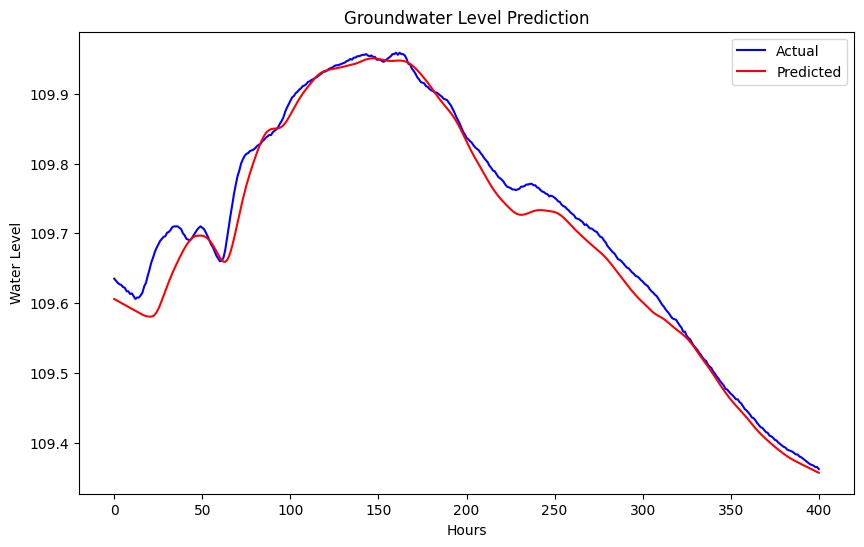

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display

def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model

window_size = 24
# Initialize lists to store the results
actual_values = []
predicted_values = []
errors = []

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(X_test.shape[0]):
    # Select the i-th sample from X_test
    X_input = X_test[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    # Make a prediction
    forecast = model.predict(X_input)
    dummy = np.zeros((1, 2))
    dummy[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy)[0, 0]

    # Store predicted values
    predicted_values.append(forecasted_value)

    # Process actual values for comparison
    actual = y_test[i] if i < len(y_test) else None
    if actual is not None:
        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]
        actual_values.append(actual_transformed)

    # Calculate absolute error
    error = abs(forecasted_value - actual_transformed)
    errors.append(error)

    # Update the plot
    ax.clear()
    ax.plot(actual_values, label='Actual', color='blue')
    ax.plot(predicted_values, label='Predicted', color='red')
    ax.set_title('Groundwater Level Prediction')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Water Level')
    ax.legend()

    # Calculate mean and std of errors over the rolling window
    if len(errors) >= window_size:
        windowed_errors = errors[-window_size:]  # Get the last 'window_size' number of errors
        mean_error = np.mean(windowed_errors)
        std_error = np.std(windowed_errors)
        threshold = mean_error + 2 * std_error  # Adjust the multiplier (2 or 3) as needed

        # Identify anomalies in the window
        windowed_anomalies = [j for j, e in enumerate(windowed_errors) if e > threshold]
        if windowed_anomalies:
            print(f"Anomalies detected at indices: {[j + i - window_size + 1 for j in windowed_anomalies]}")
            # Retrain the model with the most recent window of data
            model = retrain_model(model, X_test[i-window_size+1:i+1], y_test[i-window_size+1:i+1])


    # Display the plot
    display(fig)
    plt.pause(0.5)  # Adjust the pause time if needed

    # Clear the current output to display the next plot
    clear_output(wait=True)

# Hide the plot for the next cell
plt.close(fig)
